In [ ]:
# !pip install -r requirements.txt

In [1]:
import json
from transformers import (AutoTokenizer,
                          AutoModelForCausalLM,
                          BitsAndBytesConfig,
                          pipeline)

import torch

import pandas as pd

/root/Master_Thesis/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_data = json.load(open("config.json"))
HF_TOKEN = config_data["HF_TOKEN"]

## Quantisation Config

In [3]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

## Load Model and Tokenizer

In [4]:
model_id = "meta-llama/Meta-Llama-3-70B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id, token=HF_TOKEN)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    token=HF_TOKEN,
    device_map="auto",
    # quantization_config=bnb_config
)

/root/Master_Thesis/.conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.

## Data load

In [7]:
df = pd.read_csv("data/argument_relation_class.csv")
df

,text,label
0,"In fact as I said, a lot of the Azure use case...",1
1,"So we continue to build for high AFN, or Amazo...",1
2,"On tech and content, that's going to be a comb...",0
3,And what you'll see is that basically people u...,0
4,Our goal really is to kick-start an ecosystem ...,0
...,...,...
9793,I actually think over the next couple of years...,0
9794,"That said, I don't think it’s growing as fast ...",1
9795,So I think you do see some interplay there on ...,1
9796,"There they're really two key dynamics, the fir...",1


In [8]:
# map labels 1 to Related and 0 to Unrelated
df["label"] = df["label"].map({1: "Related", 0: "Unrelated"})
df

,text,label
0,"In fact as I said, a lot of the Azure use case...",Related
1,"So we continue to build for high AFN, or Amazo...",Related
2,"On tech and content, that's going to be a comb...",Unrelated
3,And what you'll see is that basically people u...,Unrelated
4,Our goal really is to kick-start an ecosystem ...,Unrelated
...,...,...
9793,I actually think over the next couple of years...,Unrelated
9794,"That said, I don't think it’s growing as fast ...",Related
9795,So I think you do see some interplay there on ...,Related
9796,"There they're really two key dynamics, the fir...",Related


In [9]:
# Generate 2 cols by split text column into claim and permise, please note separator is [SEP] then remove [SEP] from premise
df[["claim", "premise"]] = df["text"].str.split("\[SEP\]", n=1, expand=True)
df

,text,label,claim,premise
0,"In fact as I said, a lot of the Azure use case...",Related,"In fact as I said, a lot of the Azure use case...",I even look at the growth of virtual machine ...
1,"So we continue to build for high AFN, or Amazo...",Related,"So we continue to build for high AFN, or Amazo...",Because paid unit growth continues to be stro...
2,"On tech and content, that's going to be a comb...",Unrelated,"On tech and content, that's going to be a comb...",We're continuing to build the products that a...
3,And what you'll see is that basically people u...,Unrelated,And what you'll see is that basically people u...,because the best of the people creating those...
4,Our goal really is to kick-start an ecosystem ...,Unrelated,Our goal really is to kick-start an ecosystem ...,"And then rest of world, we saw some countries..."
...,...,...,...,...
9793,I actually think over the next couple of years...,Unrelated,I actually think over the next couple of years...,We certainly have additional delivery capabil...
9794,"That said, I don't think it’s growing as fast ...",Related,"That said, I don't think it’s growing as fast ...","I mean, you really can't tell the difference,..."
9795,So I think you do see some interplay there on ...,Related,So I think you do see some interplay there on ...,"That means more time in video, and that does ..."
9796,"There they're really two key dynamics, the fir...",Related,"There they're really two key dynamics, the fir...",The component that actually has impacted -- t...


## Import Few Shots Example

In [10]:
few_shots = pd.read_csv("top_5_similar_texts.csv")
few_shots

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_1535,text,label,original_text,claim,premise,similarity,cluster,distance,ensamble_similarity
0,-0.001166,0.015195,0.020202,0.057993,0.029780,0.020768,-0.008722,0.083361,0.015108,0.002257,...,-0.007224,Claim: So we're currently going through the pr...,Related,So we're currently going through the process o...,So we're currently going through the process o...,"I do think, as you say, this is one of the ra...",0.502003,1,1.315122,0.186880
1,0.031427,0.027280,0.018737,0.051260,0.071991,-0.006893,-0.004549,0.054455,-0.010775,0.004245,...,-0.010075,Claim: There's a lot of compute that goes behi...,Related,"There's a lot of compute that goes behind, thi...","There's a lot of compute that goes behind, thi...",But we're also making investments to support ...,0.503110,1,1.319654,0.183455
2,0.032694,0.009127,0.032994,0.077050,0.043729,-0.021170,-0.045609,0.034002,0.011429,-0.005422,...,-0.012029,Claim: And I think we're seeing impressive gro...,Related,And I think we're seeing impressive growth in ...,And I think we're seeing impressive growth in ...,We have more advertisers using the ability to...,0.490220,1,1.327836,0.162384
3,0.044543,-0.008871,-0.046620,0.072316,0.074742,0.027691,0.005908,0.040930,0.023606,-0.004914,...,-0.002469,Claim: I think what we said was that we're rea...,Related,I think what we said was that we're really ple...,I think what we said was that we're really ple...,"It's worth pointing out that, as Sheryl menti...",0.483946,1,1.331516,0.152430
4,0.027932,0.029144,-0.035976,0.045838,0.026872,-0.028263,-0.004215,0.045149,0.023511,0.014021,...,-0.015523,Claim: I think what you will see from us is al...,Related,I think what you will see from us is always a ...,I think what you will see from us is always a ...,This is one way to do it.,0.486009,1,1.333954,0.152055
5,0.032296,-0.004775,0.007295,0.041451,0.019517,0.007262,-0.003846,0.011530,-0.015853,-0.000908,...,-0.013188,Claim: And so when we look at all these things...,Unrelated,And so when we look at all these things in its...,And so when we look at all these things in its...,"But most importantly, I would go back to the ...",0.509285,0,1.310327,0.198959
6,0.026413,0.037235,0.018725,0.060326,0.047039,0.016461,-0.034583,0.070880,0.032038,-0.009449,...,-0.009677,Claim: We're seeing strong adoption across a n...,Unrelated,We're seeing strong adoption across a number o...,We're seeing strong adoption across a number o...,We've got customers that are very engaged wit...,0.503465,0,1.325382,0.178083
7,0.015836,0.003387,0.000887,0.041545,0.064141,0.028664,-0.009169,0.072977,0.013720,-0.047401,...,-0.014651,Claim: And there’s definitely some pricing act...,Unrelated,And there’s definitely some pricing action we ...,And there’s definitely some pricing action we ...,"Obviously, we're lapping what's been good per...",0.507206,0,1.339497,0.167708
8,0.015100,0.006221,-0.023336,0.050169,0.014724,-0.012665,-0.024376,0.064503,0.024290,-0.005776,...,-0.000873,Claim: But I’m really confident that this is s...,Unrelated,But I’m really confident that this is somethin...,But I’m really confident that this is somethin...,Are we growing customer bases?,0.498767,0,1.341831,0.156936
9,0.059273,0.011230,0.030089,0.033061,0.040817,0.019545,0.008647,0.102297,0.039062,-0.029495,...,0.000729,Claim: We're still focused on continuing to ha...,Unrelated,We're still focused on continuing to have that...,We're still focused on continuing to have that...,because we got a lot of customers that are wa...,0.500880,0,1.344206,0.156674


In [13]:
top_1_examples = few_shots.iloc[[0,5]]
top_1_examples

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_1535,text,label,original_text,claim,premise,similarity,cluster,distance,ensamble_similarity
0,-0.001166,0.015195,0.020202,0.057993,0.029780,0.020768,-0.008722,0.083361,0.015108,0.002257,...,-0.007224,Claim: So we're currently going through the pr...,Related,So we're currently going through the process o...,So we're currently going through the process o...,"I do think, as you say, this is one of the ra...",0.502003,1,1.315122,0.186880
5,0.032296,-0.004775,0.007295,0.041451,0.019517,0.007262,-0.003846,0.011530,-0.015853,-0.000908,...,-0.013188,Claim: And so when we look at all these things...,Unrelated,And so when we look at all these things in its...,And so when we look at all these things in its...,"But most importantly, I would go back to the ...",0.509285,0,1.310327,0.198959


In [14]:
def create_few_shot_prompt(examples):
    # Start with the base prompt explaining the task
    prompt = "Examples \n\n"

    # Add each example to the prompt
    for i, (claim, premise, label) in enumerate(examples, 1):
        prompt += f"{i}. Claim: {claim}\n   Premise: {premise}\n  Class: {label}\n"
    return prompt

In [15]:
def generate_messages(claim, premise, shots_prompt):
    messages = [
        {"role": "system", "content": "You are a helpful assistant. Given the following claim and premise and also some examples to help you understand the task more, please classify the relation between them as either Related or Unrelated. Please only generate one of the two labels."},
        {"role": "system", "content": shots_prompt},
        {"role": "user", "content": f"Claim: {claim}"},
        {"role": "user", "content": f"Premise: {premise}"}
    ]
    return messages

In [47]:
def generate_completions(messages):

  input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
  ).to(model.device)

  terminators = [
      tokenizer.eos_token_id,
      tokenizer.convert_tokens_to_ids("<|eot_id|>")
  ]
  outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.0,
  )
  response = outputs[0][input_ids.shape[-1]:]
  final_response = tokenizer.decode(response, skip_special_tokens=True)
  print(final_response)
  return final_response


In [29]:
def get_batch_llama_3_prediction_and_save(claim, premise, shots_prompt, batch_size, filename='few_shot_gpt_4_predictions.csv'):
    all_data = []
    all_objects = []
    assert len(claim) == len(premise)

    for i in range(0, len(claim), batch_size):
        batch_claim = claim[i:i + batch_size]
        batch_premise = premise[i:i + batch_size]
        for c, p in zip(batch_claim, batch_premise):
            messages = generate_messages(c, p, shots_prompt)
            completion = generate_completions(messages)
            all_data.append(completion)


    df = pd.DataFrame({"predicted_relation": all_data})
    df.to_csv(filename, index=False)
    return df

In [30]:
batch_size = 128

In [31]:
shots_prompt = create_few_shot_prompt(top_1_examples[["claim", "premise", "label"]].values.tolist())
shots_prompt

"Examples \n\n1. Claim: So we're currently going through the process of figuring out what we want to invest in over the next year and doing our long-range planning, and this is certainly one of the areas where I think we want to be investing a lot more in and believe that there's a big opportunity and can accelerate all the effort. \n   Premise:  I do think, as you say, this is one of the rare times in business where you can look at messaging platforms that exist and see how they've successfully monetized in other parts of the world and have that be a floor.\n  Class: Related\n2. Claim: And so when we look at all these things in its totality, we think that for the total company of course, we believe that revenue's going to grow. \n   Premise:  But most importantly, I would go back to the fact that we're getting better on the ad product side of being able to optimize our inventory for the advertisers in a way that will we think drive good pricing in the system for us and good outcomes f

In [32]:
claim = df["claim"]
premise = df["premise"]
assert len(claim) == len(premise)
shots_prompt = shots_prompt
print(len(claim))

9798


In [34]:
%%capture captured_output
predictions = get_batch_llama_3_prediction_and_save(claim, premise, shots_prompt, batch_size)
df['llama_3_predictions'] = predictions['predicted_relation'].to_list()
df.to_csv("llama-3-resutls.csv", index=False)
df

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

## Post Processing

In [36]:
df["llama_3_predictions"].value_counts()


llama_3_predictions
Unrelated    3919
Related      3622
Name: count, dtype: int64

In [37]:
# map "Unrelated" and "Related" to Unrelated and Related
df["llama_3_predictions"] = df["llama_3_predictions"].map({"Unrelated": "Unrelated", "Related": "Related"})

In [40]:
df["llama_3_predictions"]


0         Related
1         Related
2         Related
3         Related
4       Unrelated
          ...    
9793    Unrelated
9794          NaN
9795          NaN
9796      Related
9797      Related
Name: llama_3_predictions, Length: 9798, dtype: object

In [42]:
# if Nan then check the completion_object for "Related" or "Unrelated" and then put the value in the predicted_relation
df["llama_3_predictions"] = df["llama_3_predictions"].apply(lambda x: "Related" if "Related" in str(x) else "Unrelated")
df["llama_3_predictions"].value_counts()

llama_3_predictions
Unrelated    6176
Related      3622
Name: count, dtype: int64

In [43]:
y_true = df["label"]
y_pred = df['llama_3_predictions']

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def report_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred, labels=["Related", "Unrelated"])
    return report, confusion


              precision    recall  f1-score   support

     Related       0.78      0.58      0.66      4899
   Unrelated       0.66      0.84      0.74      4899

    accuracy                           0.71      9798
   macro avg       0.72      0.71      0.70      9798
weighted avg       0.72      0.71      0.70      9798





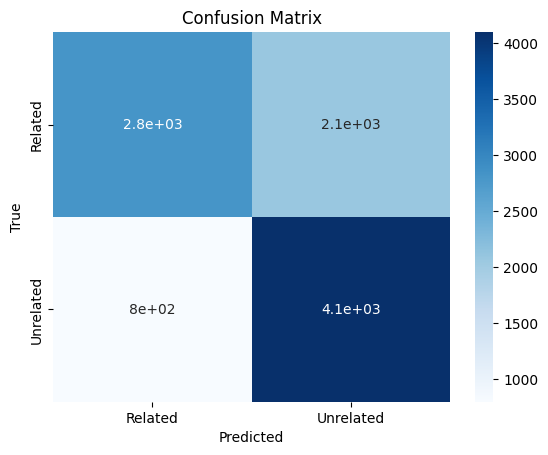

In [46]:
report, confusion = report_metrics(y_true, y_pred)
print(report)
print("\n")


# heatmap for confusion matrix and show classes and save it
sns.heatmap(confusion, annot=True, cmap="Blues", xticklabels=["Related", "Unrelated"], yticklabels=["Related", "Unrelated"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("temp_0_seed_42_llama3_70B_1_shot_classification_confusion_matrix.png")
plt.show()
